## Roller Coaster Fan Rating Random Forest Analysis + Predictions

The goal of this analysis is to identify the predict higher and lower roller coaster ratings using Machine Learning. Specifically, this notebook will generate a Random Forest to do so. We also can identify what factors contribute to higher and lower rankings. While many elements influence a coaster’s appeal, this study aims to determine which characteristics consistently lead to higher fan rankings and which ones result in lower ratings. However, the most important goal is the generated rankings as opposed to interpretability, since the individual regression tree achieved this goal. A random forest should be able to achieve much more predictive power than one regression tree.

The plan for this particular Jupyter notebook is to:

1.) Identify the hyperparamters that lead to the best random forest model.

2.) Create predictions based on Random Forest tuning parameters.

- Pros: Our prediction model won't be as prone to overfitting due to the variety of observations and features being used between different trees. 

- Cons: The results we get will be won't be as interpretable, which will help to answer our first goal.

### Read the CSV
- fill NAs if choosing not to bin continuous variables

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import pandas as pd

df = pd.read_csv("~/Documents/clean_coaster_full.csv")
# df = df.fillna('M')

In [3]:
pd.set_option('display.max_rows', 10)
df

,coaster_name,Length,Location,Status,Manufacturer,Model,Height,launch_system,Duration,year_introduced,Type_Main,speed_mph,Inversions_clean,Gforce_clean,coaster_rating
0,10 Inversion Roller Coaster,2788.8,Chimelong Paradise,Operating,Intamin,Looping Coaster,98.4,Other,92.0,2006,Steel,45.0,10,NaN,49.4
1,Abyss,2070.0,Adventure World,Operating,Gerstlauer,Euro-Fighter,98.0,Chain Lift,120.0,2013,Steel,52.8,3,4.5,64.1
2,Abyssus,4317.6,Energylandia,Operating,Vekoma,Other,126.3,LSM Launch,NaN,2021,Steel,62.1,4,4.5,91.7
3,Accelerator,590.0,Drayton Manor Theme Park,Operating,Vekoma,Family Coaster,66.0,Other,NaN,2011,Steel,37.3,0,3.0,41.8
4,Acrobat,3349.8,Nagashima Spa Land,Operating,Bolliger & Mabillard,Other,141.1,Chain Lift,180.0,2015,Steel,55.9,4,NaN,88.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,Zadra,4318.0,Energylandia,Operating,Rocky Mountain Construction,Other,206.0,Chain Lift,110.0,2019,Other,75.2,3,4.0,99.7
896,Zeus,2900.0,Mt. Olympus Water & Theme Park,Operating,Custom Coasters International,Other,90.0,Other,85.0,1997,Wood,60.0,0,NaN,72.7
897,Zippin Pippin,2865.0,Bay Beach,Operating,The Gravity Group,Wooden Out and Back,70.0,Chain Lift,118.0,1912,Wood,40.0,0,NaN,79.2
898,Zoomerang,935.0,Lake Compounce,Operating,Vekoma,Boomerang,116.5,Other,108.0,1997,Steel,47.0,3,5.2,14.9


### Model Preparation
- Because we have missing values, we'll have to deal with those before running our RF model. We'll choose to bin them with appropriate splits and then fill missing values.

In [4]:
import numpy as np

variables = {
    'Length': [0, 1000, 2000, 3000, 3500, 4500, np.inf],
    'Height': [0, 50, 75, 100, 125, 175, 225, np.inf],
    'Duration': [0, 49, 69, 89, 109, 139, 159, np.inf],
    'speed_mph': [0, 31, 39, 49, 59, 69, np.inf],  
    'Gforce_clean': [0, 2.6, 3.49, 3.99, 4.49, 4.99, np.inf]
}

labels_dict = {
    'Length': ['0-1000', '1000-2000', '2000-3000', '3000-3500', '3500-4500', '4500+'],
    'Height': ['0-50', '50-75', '75-100', '100-125', '125-175', '175-225', '225+'],
    'Duration': ['0-49', '49-69', '69-89', '89-109', '109-139', '139-159', '159+'],
    'speed_mph': ['0-31', '31-39', '39-49', '49-59', '59-69', '69+'],
    'Gforce_clean': ['0-2.6', '2.6-3.49', '3.49-3.99', '3.99-4.49', '4.49-4.99', '5+']
}

def bin_variable_custom(df, variable, bins, labels):
    df[variable] = pd.to_numeric(df[variable], errors='coerce')
    
    df[variable] = pd.cut(df[variable], bins=bins, labels=labels, include_lowest=True, right=False)
    return df

for var, bins in variables.items():
    if var in df.columns:  
        df = bin_variable_custom(df, var, bins, labels_dict[var])
    else:
        print(f"Warning: Column '{var}' not found in the DataFrame") 

- Separate bin for inversion variable

In [5]:
def bin_inversions(df, variable):
    df[variable] = pd.to_numeric(df[variable], errors='coerce')
    bins = [0, 1, 2, 4, 5, np.inf]
    labels = ['0', '1', '2', '3-4', '5+']
    df[variable] = pd.cut(df[variable], bins=bins, labels=labels, right=False)
    return df

df = bin_inversions(df, 'Inversions_clean')

- Fill NAs

In [6]:
# Add 'M' category and fill missing values for each column in sequence
for column in ['Height', 'Duration', 'Length', 'speed_mph', 'Inversions_clean', 'Gforce_clean']:
    df[column] = df[column].cat.add_categories('M')
    df[column] = df[column].fillna('M')

In [7]:
coaster_names = df['coaster_name']  
df = df.drop('coaster_name', axis=1) 

- Get dummies for all categorical variables

In [9]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns

df = pd.get_dummies(df, columns=categorical_columns)

### Train / Valid / Test Split 
- We'll split into 80 - 10 - 10 for modeling

In [10]:
# Separating Training and Testing data (80% train, 20% test)
train, valid = train_test_split(df, train_size=0.8, random_state=122)

# Splitting the validation set into validation (10%) and test (10%)
valid, test = train_test_split(valid, test_size=0.5, random_state=122)

In [11]:
X_train = train.drop(["coaster_rating"], axis = 1)
y_train = train["coaster_rating"]

X_valid = valid.drop(["coaster_rating"], axis = 1)
y_valid = valid["coaster_rating"]

X_test = test.drop(["coaster_rating"], axis=1)
y_test = test["coaster_rating"]

### Modeling

- Fit an intial tree to get OOB accuracy

In [12]:
from sklearn.ensemble import RandomForestRegressor

rf_coaster = RandomForestRegressor(n_estimators = 1000,
                                  random_state = 12345,
                                  oob_score = True)

rf_coaster.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000, oob_score=True, random_state=12345)

In [13]:
rf_coaster.oob_score_

0.6737902835825206

### Sample Feature Importance

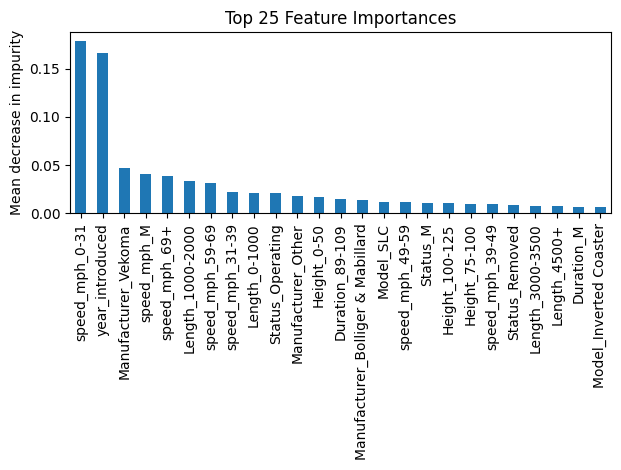

In [14]:
from matplotlib import pyplot as plt
import seaborn as sns

forest_importances = pd.Series(rf_coaster.feature_importances_, index = rf_coaster.feature_names_in_)

top_25_importances = forest_importances.sort_values(ascending=False).head(25)

fig, ax = plt.subplots()
top_25_importances.plot.bar(ax = ax)
ax.set_title("Top 25 Feature Importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

plt.show()

### Randomized Search

- Let's look at a Randomized Search to see what features work best to tune our Random Forest.

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'bootstrap': [True, False],  
    'max_features': np.linspace(5, 150, num=20, dtype=int).tolist(),  
    'n_estimators': np.arange(500, 3000, 250).tolist(),  
    'max_depth': np.append(np.arange(10, 110, 10), None).tolist(),  
    'min_samples_split': np.arange(2, 20, 2).tolist(),  
    'min_samples_leaf': np.arange(1, 20, 2).tolist(),  
}

rf = RandomForestRegressor(random_state = 122)

random_search = RandomizedSearchCV(
    estimator=rf, 
    param_distributions=param_grid, 
    n_iter=100,  
    cv=10, 
    random_state=122,
    n_jobs=-1  
)

random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(random_state=122),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': [5, 12, 20, 27, 35, 43,
                                                         50, 58, 66, 73, 81, 88,
                                                         96, 104, 111, 119, 127,
                                                         134, 142, 150],
                                        'min_samples_leaf': [1, 3, 5, 7, 9, 11,
                                                             13, 15, 17, 19],
                                        'min_samples_split': [2, 4, 6, 8, 10,
                                                              12, 14, 16, 18],
                                        'n_estimators': [500, 750, 1000, 1250,
                                                         1500, 1750, 2000, 2250,
                                                         2500, 2750]},
                   random_state=122)

- Get the best paramaters

In [23]:
random_search.best_params_

{'n_estimators': 750,
 'min_samples_split': 6,
 'min_samples_leaf': 1,
 'max_features': 43,
 'max_depth': 50,
 'bootstrap': True}

### Compare features with random variable

- We'll create a model with the tuning parameters we just used, and we'll compare each variable to the random variable.

In [24]:
import numpy as np

X_train_r = X_train

X_train_r['random'] = np.random.normal(0, 1, 720)

In [25]:
rf_coaster_best_train = RandomForestRegressor(
                                n_estimators = 750,
                                min_samples_split = 6,
                                min_samples_leaf = 1,
                                max_features = 43,
                                max_depth = 50,
                                bootstrap = True,
                                random_state = 122,
                                oob_score = True)

rf_coaster_best_train.fit(X_train_r, y_train)

RandomForestRegressor(max_depth=50, max_features=43, min_samples_split=6,
                      n_estimators=750, oob_score=True, random_state=122)

### Feature Importances
- We could consider dropping each feature below the random variable

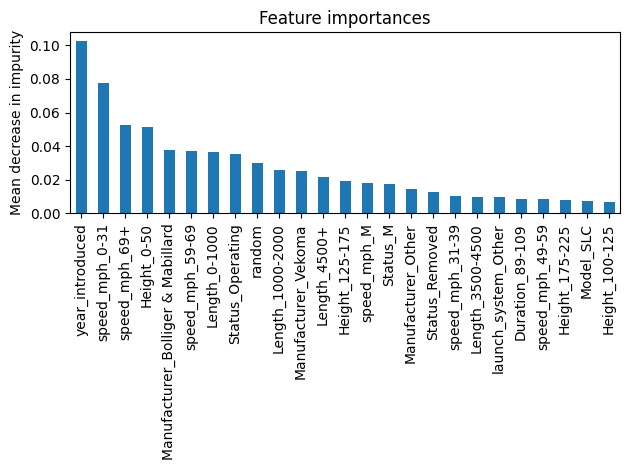

In [26]:
forest_importances = pd.Series(rf_coaster_best_train.feature_importances_, index = rf_coaster_best_train.feature_names_in_)

top_25_importances = forest_importances.sort_values(ascending=False).head(25)

fig, ax = plt.subplots()
top_25_importances.plot.bar(ax = ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

plt.show()

In [27]:
df = pd.read_csv("~/Documents/clean_coaster_full.csv")

In [28]:
df = df[["speed_mph", "Length", "Height", "year_introduced", "Duration", "Gforce_clean", "Inversions_clean", "Status", "coaster_rating", "Manufacturer"]]

In [29]:
categorical_columns = df.select_dtypes(include=['object']).columns

df = pd.get_dummies(df, columns=categorical_columns)

In [31]:
# Separating Training and Testing data (80% train, 20% test)
train, valid = train_test_split(df, train_size=0.8, random_state=122)

# Splitting the validation set into validation (10%) and test (10%)
valid, test = train_test_split(valid, test_size=0.5, random_state=122)

In [32]:
X_train = train.drop(["coaster_rating"], axis = 1)
y_train = train["coaster_rating"]

X_valid = valid.drop(["coaster_rating"], axis = 1)
y_valid = valid["coaster_rating"]

X_test = test.drop(["coaster_rating"], axis=1)
y_test = test["coaster_rating"]

In [33]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'bootstrap': [True],
    'max_depth': [40, 50, 55, None],
    'max_features': [40, 45, 50, 55, None],
    'min_samples_split': [6, 7, None],
    'n_estimators': [750, 850, 1000, None]
}

rf = RandomForestRegressor(random_state = 122)

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 10)

grid_search.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
1200 fits failed out of a total of 2400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
400 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3

GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=122),
             param_grid={'bootstrap': [True], 'max_depth': [40, 50, 55, None],
                         'max_features': [40, 45, 50, 55, None],
                         'min_samples_split': [6, 7, None],
                         'n_estimators': [750, 850, 1000, None]})

In [34]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 40,
 'max_features': 40,
 'min_samples_split': 6,
 'n_estimators': 1000}

In [35]:
rf_coaster_best_train = RandomForestRegressor(n_estimators = 1000,
                                  max_features = 40,
                                  max_depth = 40,
                                  min_samples_split = 6,
                                  random_state = 122,
                                  oob_score = True)

rf_coaster_best_train.fit(X_train, y_train)

RandomForestRegressor(max_depth=40, max_features=40, min_samples_split=6,
                      n_estimators=1000, oob_score=True, random_state=122)

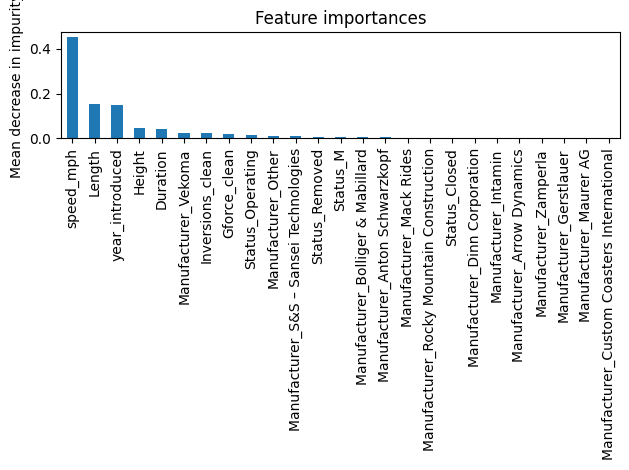

In [36]:
forest_importances = pd.Series(rf_coaster_best_train.feature_importances_, index = rf_coaster_best_train.feature_names_in_)

top_25_importances = forest_importances.sort_values(ascending=False).head(25)

fig, ax = plt.subplots()
top_25_importances.plot.bar(ax = ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

plt.show()

In [37]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

# Make predictions on the training set
y_train_pred = rf_coaster_best_train.predict(X_train)
# train_full['predictions'] = y_train_pred_cv

# Calculate the Mean Absolute Error (MAE)
mae_train_cv = mean_absolute_error(y_train, y_train_pred)

# Calculate MAPE for training data
mape_train_cv = mean_absolute_percentage_error(y_train, y_train_pred)

# Print the MAE for the training data
print("MAE for Training data:", mae_train_cv)

# Print the MAPE
print("MAPE for Training Data: ", mape_train_cv)

MAE for Training data: 5.461324707417592
MAPE for Training Data:  0.2440758044658935


In [38]:
y_valid_pred_ = rf_coaster_best_train.predict(X_valid)

In [39]:
# Calculate the Mean Absolute Error (MAE) for validation data
mae_valid_cv = mean_absolute_error(y_valid, y_valid_pred_)

# Calculate MAPE for validation data
mape_valid_cv = mean_absolute_percentage_error(y_valid, y_valid_pred_)

# Print the MAE for the validation data
print("MAE for Validation data:", mae_valid_cv)

# Print the MAPE for the validation data
print("MAPE for Validation Data: ", mape_valid_cv)


MAE for Validation data: 12.154200953265883
MAPE for Validation Data:  0.3097411171023966


In [40]:
# Combine the training and validation sets
train_valid = pd.concat([train, valid], axis=0)

# Separate features and target for combined dataset
X_train_valid = train_valid.drop("coaster_rating", axis=1)
y_train_valid = train_valid["coaster_rating"]

In [41]:
rf_coaster_best_train.fit(X_train_valid, y_train_valid)

RandomForestRegressor(max_depth=40, max_features=40, min_samples_split=6,
                      n_estimators=1000, oob_score=True, random_state=122)

In [42]:
y_test_pred = rf_coaster_best_train.predict(X_test)

In [43]:
# Calculate the Mean Absolute Error (MAE) for test data
mae_test_cv = mean_absolute_error(y_test, y_test_pred)

# Calculate MAPE for test data
mape_test_cv = mean_absolute_percentage_error(y_test, y_test_pred)

# Print the MAE for the test data
print("MAE for Test data:", mae_test_cv)

# Print the MAPE for the test data
print("MAPE for Test Data: ", mape_test_cv)

MAE for Test data: 12.441957999803297
MAPE for Test Data:  0.45782635982670583


In [133]:
import pandas as pd
import numpy as np

# Create a DataFrame with the actual and predicted values
comparison_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_test_pred
})
pd.set_option('display.max_rows', None)
# Display the DataFrame
print(comparison_df)

# Calculate the absolute percentage error for each row
comparison_df['APE'] = np.abs((comparison_df['Actual'] - comparison_df['Predicted']) / comparison_df['Actual']) * 100

# Calculate MAPE
mape = comparison_df['APE'].mean()

print(f"MAPE: {mape}")

     Actual  Predicted
554    19.6  16.454310
216    73.7  73.035944
401    59.8  47.791335
656    97.8  89.074667
10     48.1  20.872988
301    89.6  88.051379
116    63.7  60.080833
717    97.4  89.303722
727    94.6  93.260958
713    89.4  89.703889
367    47.9  45.150300
866    78.7  45.252986
274    34.0  49.256975
56     86.8  64.601492
349    63.2  54.023567
347    83.9  77.938694
754    25.4  30.174162
825    72.8  55.626000
637    73.3  72.820639
496    37.3  45.159886
597    64.2  63.733172
98     23.0  39.659542
494    66.5  63.820682
342    42.0  40.457599
566    62.1  53.084311
765    87.4  82.258389
615     9.3  23.325556
398    64.4  56.669733
218    30.3  28.782599
231    30.0  28.518942
791    85.5  86.151306
595    60.0  46.854040
235    15.0  22.143103
140    66.3  52.170196
551    18.3  43.861964
252    63.6  76.288324
581    23.9  39.591147
23     99.5  89.067192
547    73.7  60.520479
701    50.0  41.649375
515    25.4  23.881810
875    82.5  85.607458
639     6.3

In [44]:
y_test_pred_list = pd.Series(y_test_pred, index=y_test.index)

In [45]:
comparison_df = pd.concat([
    pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred_list})
])

In [46]:
comparison_df

,Actual,Predicted
202,87.0,74.556436
93,14.4,44.021977
702,38.9,65.801258
461,68.6,59.485092
704,41.9,51.228732
...,...,...
75,61.2,54.108860
720,57.8,42.822744
899,8.5,20.703912
651,59.5,71.781728


In [47]:
df = pd.read_csv("~/Documents/clean_coaster_full.csv")
accuracy = df["coaster_name"]

In [48]:
# Join on index
comparison_df = comparison_df.join(coaster_names)

# Move coaster_name to the first column for clarity
comparison_df = comparison_df[['coaster_name', 'Actual', 'Predicted']]

In [49]:
comparison_df = comparison_df.sort_values(by="Actual", ascending=False)

In [50]:
comparison_df['Closest'] = (comparison_df['Actual'] - comparison_df['Predicted']).abs()
comparison_df['Percent_Off'] = ((comparison_df['Actual'] - comparison_df['Predicted']).abs() / comparison_df['Actual']) * 100
comparison_df.head()

,coaster_name,Actual,Predicted,Closest,Percent_Off
371,Kondaa,98.5,92.485319,6.014681,6.106275
889,X2,97.1,91.498434,5.601566,5.768863
482,Pantheon,96.8,94.365142,2.434858,2.515349
673,Superman The Ride,96.4,91.024222,5.375778,5.576534
427,Millennium Force,96.2,88.646564,7.553436,7.851804


In [51]:
comparison_df

,coaster_name,Actual,Predicted,Closest,Percent_Off
371,Kondaa,98.5,92.485319,6.014681,6.106275
889,X2,97.1,91.498434,5.601566,5.768863
482,Pantheon,96.8,94.365142,2.434858,2.515349
673,Superman The Ride,96.4,91.024222,5.375778,5.576534
427,Millennium Force,96.2,88.646564,7.553436,7.851804
...,...,...,...,...,...
768,Tigre de Sibérie,8.6,22.191950,13.591950,158.045926
899,Zydeco Scream,8.5,20.703912,12.203912,143.575432
639,Steamin' Demon,6.3,30.968511,24.668511,391.563672
40,Bat,4.7,21.365535,16.665535,354.585849
